## Importing libraries

In [1]:
import gymnasium as gym
import pde_control_gym
import numpy as np
%matplotlib inline
import os
import matplotlib.pyplot as plt

import stable_baselines3
import time
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CallbackList

2025-06-24 20:57:26.592734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 20:57:26.592793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 20:57:26.593944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 20:57:26.603204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initializing Gym

In [2]:
T = 240
dt = 0.25
dx = 10
X = 500

from pde_control_gym.src import TrafficARZReward
reward_class =  TrafficARZReward()

Parameters = {
        "T": T, 
        "dt": dt, 
        "X": X,
        "dx": dx, 
        "reward_class": reward_class,
        "simulation_type" : 'outlet-train', 
        "v_steady" : 10,
        "ro_steady" : 0.12,
        "v_max" : 40,
        "ro_max" : 0.16,
        "tau" : 60, 
        "limit_pde_state_size" : True,
        "control_freq" : 2
}

In [ ]:
#Declaring required callbacks for checkpointing and logging
checkpoint_callback = CheckpointCallback(
  save_freq=50000,
  save_path="./logsPPO",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)

    def _on_step(self):
        # Log the rewards at each step to TensorBoard
        self.logger.record('reward', np.mean(self.locals['rewards']))
        return True
reward_logging_callback = RewardLoggingCallback()
callback_list = CallbackList([checkpoint_callback,reward_logging_callback])

Parameters["simulation_type"] = 'outlet-train'
envRL = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)

model = PPO("MlpPolicy",envRL, verbose=1, tensorboard_log="./tb/")

#Training the model (Trained models are avaiable in our HuggingFace repo)
model.learn(total_timesteps=1500000, callback=callback_list)

In [ ]:
def runSingleEpisode(model, env, parameter = None):
    terminate = False
    truncate = False

    # Holds the resulting states 
    uStorage = []

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    ns = 0
    i = 0
    rew = 0

    #Storing action and reward history
    act_h = []
    rew_h = []
    while not truncate and not terminate:
        # use backstepping controller
        action = model(env,obs,parameter)
        act_h.append(action)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards
        rew_h.append(rewards)
        ns += 1
        
    u = np.array(uStorage)
    return rew, u, act_h, rew_h


def RLController(env,obs,model):
    
    #Normalization of observation space
    half = obs.shape[0] // 2
    r = obs[:half]
    v = obs[half:]
    obs_sc = np.reshape(
        np.concatenate(((r - env.unwrapped.rs) / env.unwrapped.rs, (v - env.unwrapped.vs) / env.unwrapped.vs)),
        -1
    )

    #Predicting action using RL model
    action, _state = model.predict(obs_sc)
    
    if env.unwrapped.simulation_type == 'outlet':
        return action[0]
    elif env.unwrapped.simulation_type == 'both':
        return (env.unwrapped.qs, action[0])

## Outlet Control


In [4]:
Parameters["simulation_type"] = 'outlet'
Parameters["control_freq"] = 1
PPO_model = PPO.load('./logsPPO/rl_model_1500000_steps.zip')
env = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
rew, u, act_h, rew_h = runSingleEpisode(RLController, env, PPO_model)

Case 1: Outlet Boundary Control
Steady state density, velocity:  0.12 , 10


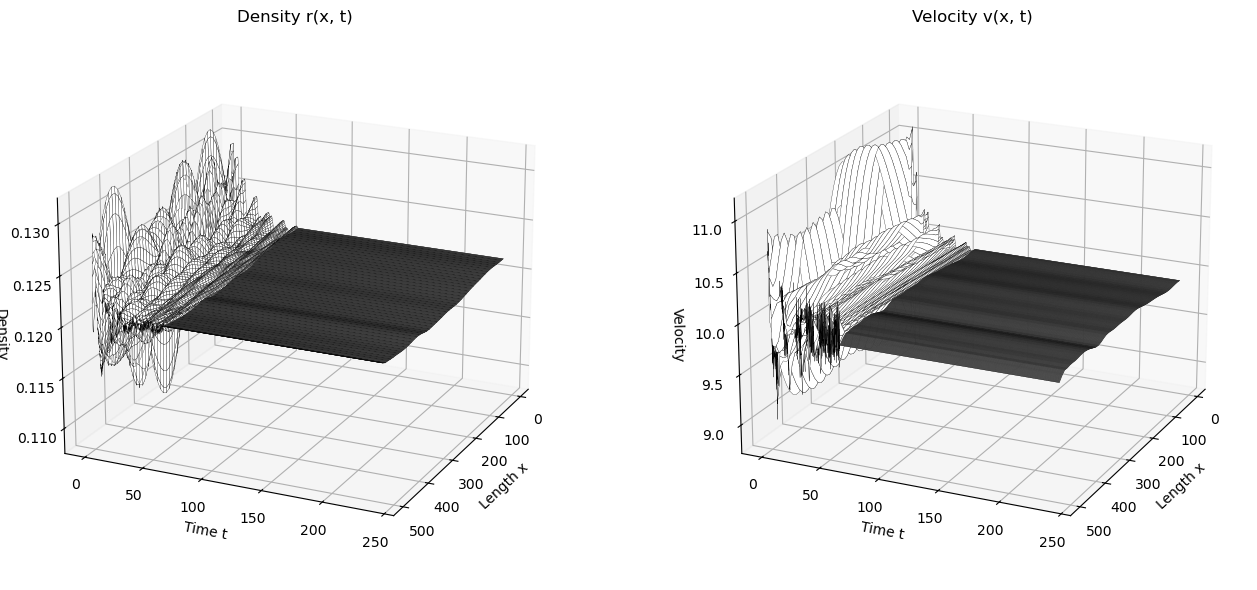

In [5]:
# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, u.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, u[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=5, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, u[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=5, cstride=100,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

# Set side view for both plots
ax1.view_init(elev=20, azim=25)
ax2.view_init(elev=20, azim=25)


plt.tight_layout()
plt.show()

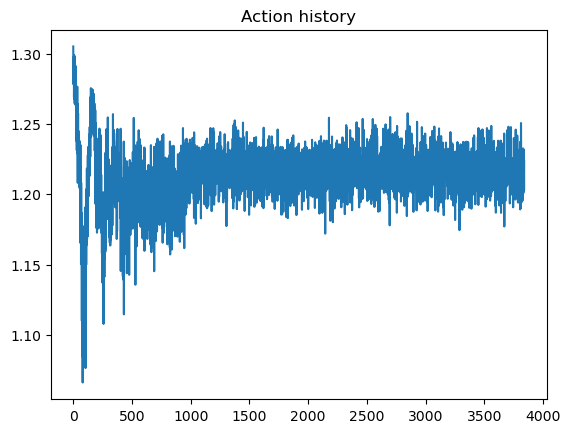

In [6]:
plt.plot(act_h)
plt.title("Action history")
plt.show()

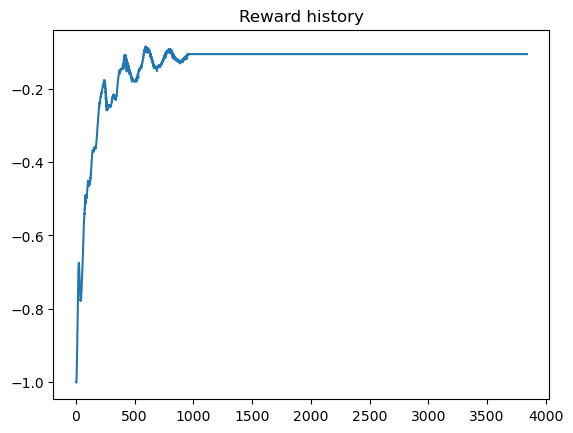

In [7]:
plt.plot(rew_h)
plt.title("Reward history")
plt.show()

## Inlet and outlet control


In [8]:
Parameters["simulation_type"] = 'both'
Parameters["control_freq"] = 1
PPO_model = PPO.load('./logsPPO/rl_model_1500000_steps.zip')
env = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
rew, u, act_h, rew_h = runSingleEpisode(RLController, env, PPO_model)

Case 3: Outlet & Inlet Boundary Control
Steady state density, velocity:  0.12 , 10


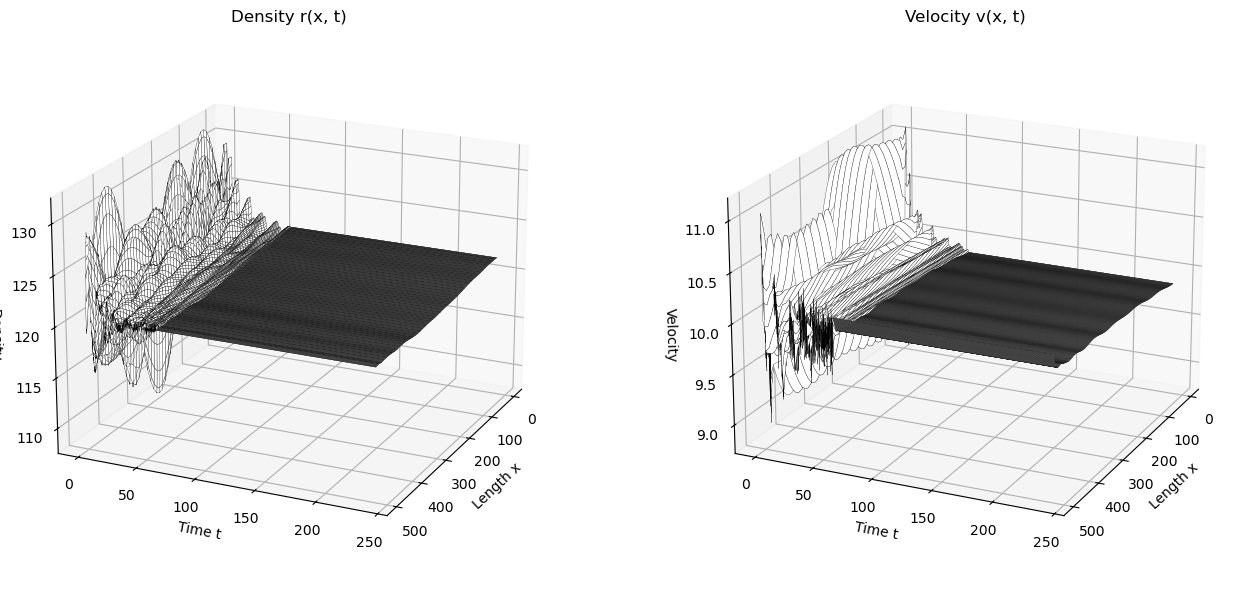

In [9]:
# Scale density
u[:, :50] *= 1000

# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, u.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, u[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=5, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, u[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=5, cstride=100,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

# Set side view for both plots
ax1.view_init(elev=20, azim=25)
ax2.view_init(elev=20, azim=25)


plt.tight_layout()
plt.show()